In [ ]:
%matplotlib inline 
import sys 
from matplotlib.ticker import FormatStrFormatter
import xarray as xr
import numpy as np
import os 
import warnings
import yaml
from random import randint
import math
from datetime import datetime, timedelta

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
config = ['/home/jvalenti/scratch/OParcels_runs/Parcels_outfall/outfall_runs.yaml']
path_runs = '/home/jvalenti/MOAD/results/Graham/' 
path_NEMO = make_prefix(datetime(2019, 1, 1),'NEMO_path')
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')

In [6]:
coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')

In [7]:
def interpolate_to_grid(lat, lon, mask=mask):
    """
    Interpolate latitude and longitude to fractional grid coordinates in an irregular grid.

    Parameters:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        grid_lat (xarray.DataArray): Latitude values of the grid.
        grid_lon (xarray.DataArray): Longitude values of the grid.

    Returns:
        tuple: (x_grid, y_grid) as fractional grid coordinates.
    """
    grid_lat = mask.nav_lat
    grid_lon = mask.nav_lon
    distance = ((grid_lat - lat)**2 + (grid_lon - lon)**2)**0.5
    idx_min = distance.argmin()
    y_index, x_index = divmod(idx_min.values, grid_lon.shape[1])

    # Calculate fractional offsets (delta lat/lon to grid spacing)
    try: x_offset = (lon - grid_lon[y_index, x_index]) / (grid_lon[y_index, x_index + 1] - grid_lon[y_index, x_index])
    except IndexError:
        x_offset = (lon - grid_lon[y_index, x_index]) / (grid_lon[y_index, x_index - 1] - grid_lon[y_index, x_index])
    try:y_offset = (lat - grid_lat[y_index, x_index]) / (grid_lat[y_index + 1, x_index] - grid_lat[y_index, x_index])
    except IndexError:
        y_offset = (lat - grid_lat[y_index, x_index]) / (grid_lat[y_index - 1, x_index] - grid_lat[y_index, x_index])
    return float(x_index + x_offset), float(y_index + y_offset)

In [8]:
def finder2(target_lat, target_lon,mask=mask):
# Load grid data (e.g., from a NetCDF file)
    lat = mask.nav_lat
    lon = mask.nav_lon

    #find closest grid
    distance = ((lat - target_lat)**2 + (lon - target_lon)**2)**0.5
    nearest_index = distance.argmin()
    return int(nearest_index // lon.shape[1]), int(nearest_index % lon.shape[1])
     

Text(0.5, 1.0, 'Salish Sea subregions')

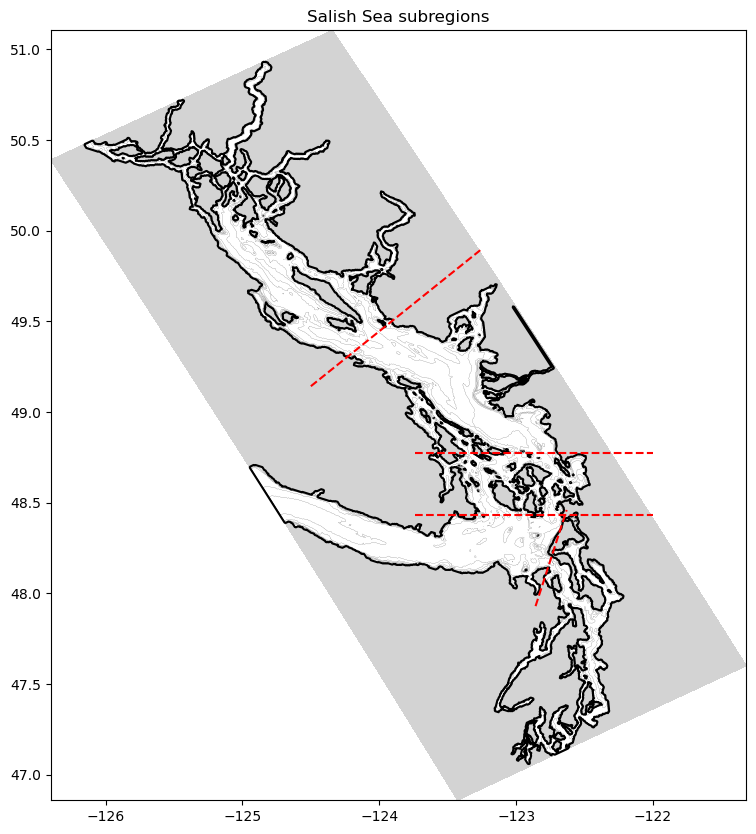

In [9]:
from matplotlib import pyplot as plt,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,1,figsize=(10, 10))

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
#aa = ax.hist2d(DS.lon,DS.lat,100,cmap =cm,vmin=1e-5,vmax=2000)
ax.set_aspect(1/np.sin(np.deg2rad(49)))
Xline = np.linspace(-124.5,-122,100)
yline0 = (7/3)*Xline+334.6
yline1 = (20/33)*Xline+124.597
yline2 = np.zeros_like(Xline)+48.43
yline3 = np.zeros_like(Xline)+48.774
plt.plot(Xline[65:75],yline0[65:75],'r--')
plt.plot(Xline[:50],yline1[:50],'r--')
plt.plot(Xline[30:],yline2[30:],'r--')
plt.plot(Xline[30:],yline3[30:],'r--')

plt.title('Salish Sea subregions')

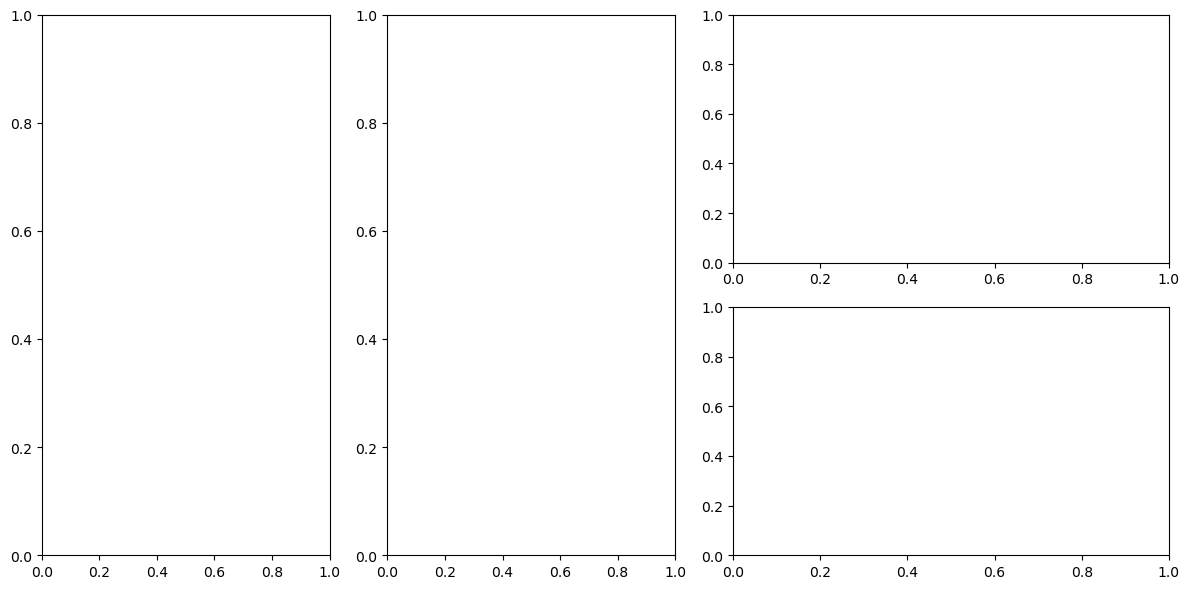

In [10]:
import matplotlib.gridspec as gridspec

# Create a figure and a GridSpec layout
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[0.66, 0.66, 1])

# Add the first two single large figures (one per column)
ax1 = fig.add_subplot(gs[:, 0])  # Occupies both rows in column 1
ax2 = fig.add_subplot(gs[:, 1])  # Occupies both rows in column 2

# Add the third column with two stacked subplots
ax3 = fig.add_subplot(gs[0, 2])  # Upper subplot in column 3
ax4 = fig.add_subplot(gs[1, 2])  # Lower subplot in column 3

# Adjust layout for better visualization
plt.tight_layout()
plt.show()
axes = fig.get_axes()


In [11]:
import pandas as pd
Point_At = pd.read_csv('Book1.csv')
Time=np.linspace(0,365,8017)

Source = pd.read_csv('Outfall_deploy.csv')
Source = Source.rename(columns={'Lat': 'lat', 'Lon': 'lon'})

In [12]:
runs = {'250 s':['alpha120190101.nc',2],'500 s':['alpha_1_jan.nc',2],'1,000 s':['alpha220190101.nc',2],'2,500 s':['Runs_alpha0220190101_.nc',1],'5,000 s':['Run_Enero20190101_.nc',2],'10,000 s':['Runs_alpha0520190101_.nc',1],'50,000 s':['Runs_alpha0120190101_.nc',1]}

months = {'Jan':['Run_Enero20190101_.nc',1],'Feb':['Run_Febrero20190201_.nc',1],'Mar':['Run_Marzo20190301_.nc',1],'Jun':['Run_Junio20190601_.nc',1],'Jul':['Run_Julio20190701_.nc',1],'Aug':['Run_Agosto20190801_.nc',1]}

sub_areas=['Puget','JdF','Haro2','NSoG','CSSoG']
def cutting(data,area):
    if area=='Puget':
        data_new = data.loc[(data['lat']<48.43) & (data['lat']<(7/3)*data['lon']+334.6)]
    elif area=='JdF':
        data_new = pd.concat([data.loc[((data['lat']<48.43) & (data['lat']>(7/3)*data['lon']+334.6))],data.loc[((data['lat']>48.43) & (data['lat']<48.774) & (data['lon']<-124))]])
    elif area=='Haro':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-123.456) & (data['lon']<-123)]
    elif area=='Haro2':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-124)]
    elif area=='NSoG':
        data_new = data.loc[(data['lat']>(20/33)*data['lon']+124.597)]
    elif area=='CSSoG': 
        data_new = data.loc[(data['lat']>48.774)&(data['lat']<(20/33)*data['lon']+124.597)]
    else:
        print('Unrecognized subarea') 
        data_new = data
    return data_new

In [13]:
volume = (mask.e1t[0,:,:]*(mask.e2t[0,:,:])*(mask.e3t_0[0,:,:,:]))
maskt = mask.tmask[0,:,:,:]
total_volume = np.sum(maskt* volume)

In [14]:
concs = {'180 s':['alpha120190101.npy',2],'360 s':['alpha_1_jan.npy',2],'720 s':['alpha220190101.npy',2],'1,800 s':['Runs_alpha0220190101_.npy',1],'3,600 s':['Run_Enero20190101_.npy',1],'6,120 s':['Runs_alpha0520190101_.npy',1],'36,000 s':['Runs_alpha0120190101_.npy',1]}


#alphs = {'250 s':250,'500 s':500,'1,000 s':1000,'2,500 s':2500,'5,000 s':5000,'10,000 s':10000,'50,000 s':50000}
#alphs = {'180 s':0.05,'360 s':0.1,'720 s':0.2,'1,800 s':0.5,'3,600 s':1,'6,120 s':1.7,'36,000 s':10}
alphs = {'180 s':14.5,'360 s':7.23,'720 s':3.6,'1,800 s':1.4,'3,600 s':0.7,'6,120 s':0.4,'36,000 s':0.07}


xs =np.array(list(alphs.values()))
masktt=maskt[:,::3,::3]
conc_mean = []
weighted_nanmean =[]
weighted_q1 = []
weighted_q3 = []
conc_sd = []
weights = mask.e3t_0[0,:,::3,::3]
TD = np.nansum(np.where(masktt,weights,np.nan).ravel())
weights = np.where(masktt,weights,np.nan)/TD
for alp in alphs:
    conc = np.load(path_runs+concs[alp][0])/concs[alp][1]
    conc = np.where(masktt,conc,np.nan)
    masknan = ~np.isnan(conc)
    data_cleaned = conc[masknan]
    weights_cleaned = weights[masknan]
    weighted_mean=np.average(data_cleaned, weights=weights_cleaned)
    weighted_nanmean.append(weighted_mean)
    #conc_mean.append(np.nanmean(np.nanmean(np.nanmean(conc,axis=2),axis=1)))
    #conc_sd.append(np.nanstd(np.nanstd(np.nanstd(conc,axis=2),axis=1)))
#plt.plot(xs, weighted_nanmean, '.', label="data")
p0 = axes[3].plot(xs,weighted_nanmean,'.--',label = r'Concentration [MF m$^{-3}$]',markersize=10)
#axes[3].set_xscale('log')

In [15]:
import math

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    
    Parameters:
        lat1, lon1: Latitude and longitude of point 1 in decimal degrees.
        lat2, lon2: Latitude and longitude of point 2 in decimal degrees.
    
    Returns:
        Distance in kilometers.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371000 # Radius of Earth in kilometers
    return r * c

In [16]:
# travel_all = []
# for alpha in runs:
#     print(alpha)
#     ds = xr.open_dataset(path_runs+runs[alpha][0], decode_times=False)
#     x = np.linspace(0,31,ds.dims['obs']-1)
#     DS = ds.to_dataframe()
#     DS = DS.dropna()
    
#     dist_travel = []
#     for i in range(len(DS.lat)):
#         try: leni = len(DS.lat[i])
#         except KeyError:
#             break
#         dist_travel.append(haversine(DS.lat[i][0],DS.lon[i][0],DS.lat[i][leni-1],DS.lon[i][leni-1]))
#     travel_all.append(dist_travel)
# np.save('distance_travelled.npy',np.array(travel_all))

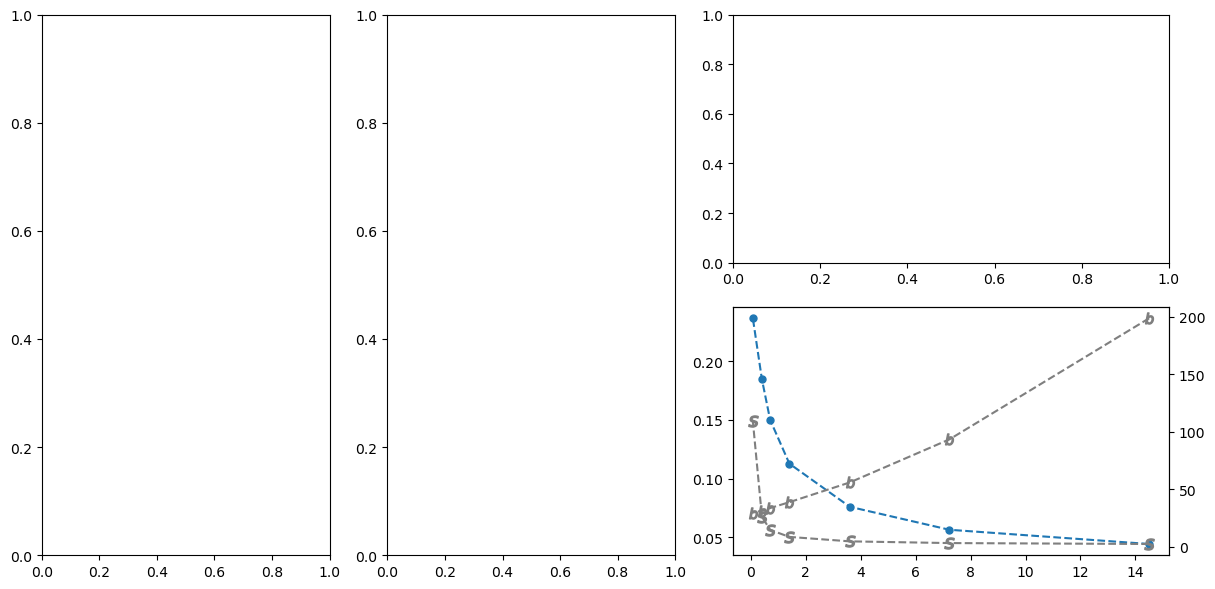

In [17]:
#np.save('sinkrates_alpha.npy',np.array(out))
axes4 = plt.twinx(axes[3])
out = np.load('sinkrates_alpha.npy')
beached = []
sedimented= []
for alpha in out:
    beached.append(alpha[0])
    sedimented.append(alpha[1])
p2 = axes4.plot(xs,np.array(beached),'--',c='tab:grey',label = r'Beaching rate [d$^{-1}$]',markersize=8,marker='$b$')
axes4.plot(xs,np.array(sedimented),'--',c='tab:grey',label = r'Sedimentation rate [d$^{-1}$]',markersize=8,marker = '$s$')

fig

In [18]:
alphs_old = {'250 s':250,'500 s':500,'1,000 s':1000,'2,500 s':2500,'5,000 s':5000,'10,000 s':10000,'50,000 s':50000}

a=[]
sd=[]
for alpha in alphs_old:
    a.append(np.mean(np.load('distance_travelled'+str(alpha)+'.npy'))/1e3)
    sd.append(np.std(np.load('distance_travelled'+str(alpha)+'.npy'))/1e3)

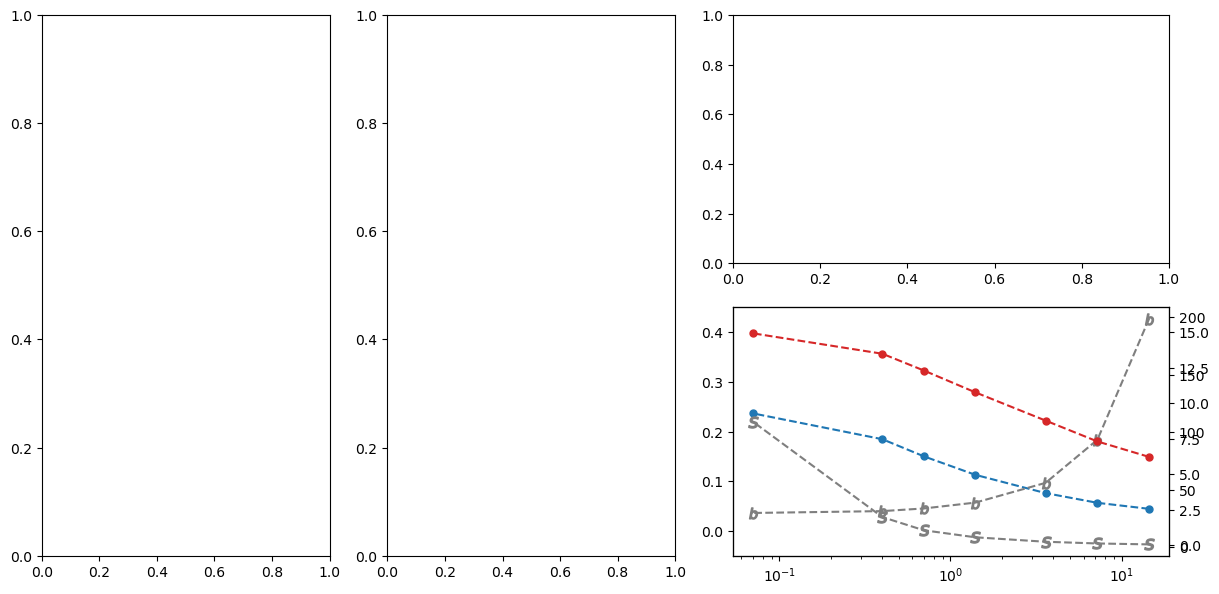

In [19]:
axes3 = plt.twinx(axes[3])
p1 = axes3.plot(xs,a,'.--',c='tab:red',label = r'Distance travelled [km]',markersize=10)
axes3.set_xscale('log')
handles0, labels0 = axes[3].get_legend_handles_labels()
handles, labels = axes3.get_legend_handles_labels()
handles1, labels1 = axes4.get_legend_handles_labels()
#axes[3].legend(handles=handles+handles0+handles1, labels=labels+labels0+handles1,loc=2)
axes[3].set_ylim(-0.05,0.45)
axes3.set_ylim(-0.75,16.75)
fig
#plt.errorbar(xs,a,yerr=sd)

In [20]:
maskbathy = np.where(masktt[0,:,:],mask.mbathy[0,::3,::3],np.nan)-1
maskbathy[np.isnan(maskbathy)]=0

In [21]:
conc = np.load(path_runs+concs[alp][0])/concs[alp][1]

In [22]:
# concs = {'250 s':['alpha120190101.npy',2],'500 s':['alpha_1_jan.npy',2],'1,000 s':['alpha220190101.npy',2],'2,500 s':['Runs_alpha0220190101_.npy',1],'5,000 s':['Run_Enero20190101_.npy',1],'10,000 s':['Runs_alpha0520190101_.npy',1],'50,000 s':['Runs_alpha0120190101_.npy',1]}

# months = {'Jan':['Run_Enero20190101_.npy',1],'Feb':['Run_Febrero20190201_.npy',1],'Mar':['Run_Marzo20190301_.npy',1],'Jun':['Run_Junio20190601_.npy',1],'Jul':['Run_Julio20190701_.npy',1],'Aug':['Run_Agosto20190801_.npy',1]}
# monthy = {'Jan':1,'Feb':2,'Mar':3,'Jun':6,'Jul':7,'Aug':8}


# conc_dep = []
# for alp in months:
#     conc = np.load(path_runs+months[alp][0])/months[alp][1]
#     conc = np.where(masktt,conc,np.nan)
#     for i in range(300):
#         for j in range(133):
#             conc[int(maskbathy[i,j]):,i,j]=np.nan
#     conc_dep.append(np.nanmean(np.nanmean(conc,axis=1),axis=1))#np.nanmean(np.nanmean(conc,axis=2),axis=1))
# X,Y =np.meshgrid(list(monthy.values()) ,mask.gdept_0[0,:,0,0])
# aa = axes[2].pcolormesh(X,Y,np.array(conc_dep).T,cmap=cmocean.cm.dense)
# levelsz =20+np.nanargmax(np.array(conc_dep)[:,20:],axis=1)
# zsub_max = []
# for zi in levelsz: 
#     zsub_max.append(mask.gdept_0[0,zi,0,0])
# sc= axes[2].scatter(np.array(list(monthy.values())),zsub_max,marker="*",c='r',label='Subsurface Max')

# axes[2].set_ylim(400,0)
# axes[2].set_xlim(3600/50050,3600/200)
# axes[2].legend(loc=3)
# fig

/tmp/ipykernel_135250/2037444877.py:10: RuntimeWarning: Mean of empty slice
  conc_dep.append(np.nanmean(np.nanmean(conc,axis=1),axis=1))#np.nanmean(np.nanmean(conc,axis=2),axis=1))


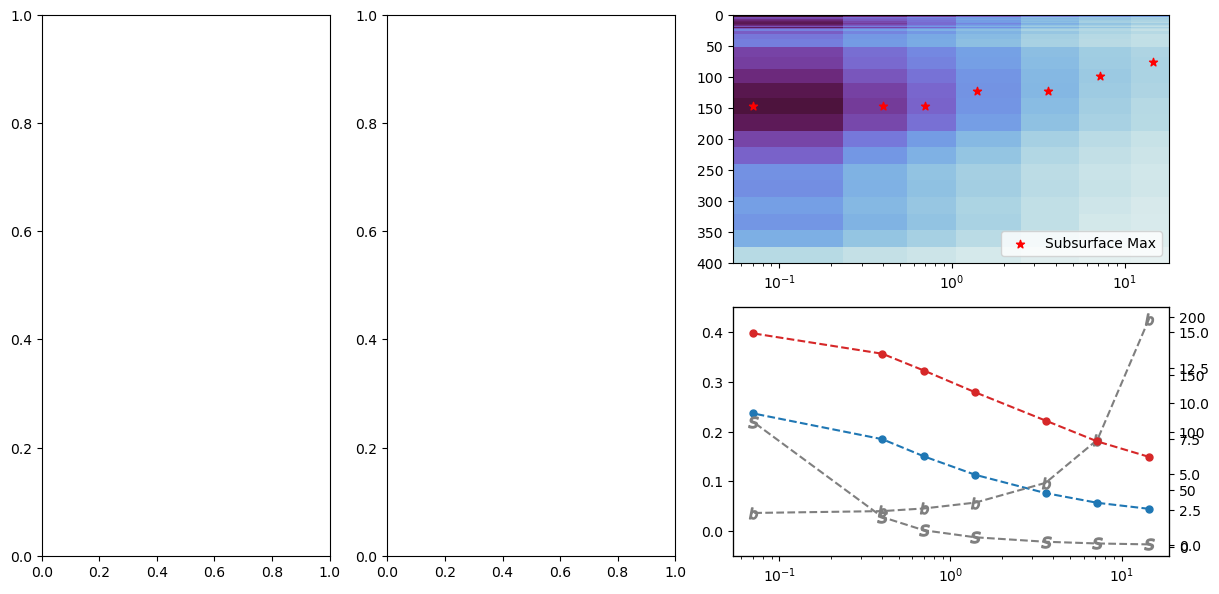

In [23]:
#concs = {'250 s':['alpha120190101.npy',2],'500 s':['alpha_1_jan.npy',2],'1,000 s':['alpha220190101.npy',2],'2,500 s':['Runs_alpha0220190101_.npy',1],'5,000 s':['Run_Enero20190101_.npy',1],'10,000 s':['Runs_alpha0520190101_.npy',1],'50,000 s':['Runs_alpha0120190101_.npy',1]}

conc_dep = []
for alp in alphs:
    conc = np.load(path_runs+concs[alp][0])/concs[alp][1]
    conc = np.where(masktt,conc,np.nan)
    for i in range(300):
        for j in range(133):
            conc[int(maskbathy[i,j]):,i,j]=np.nan
    conc_dep.append(np.nanmean(np.nanmean(conc,axis=1),axis=1))#np.nanmean(np.nanmean(conc,axis=2),axis=1))
X,Y =np.meshgrid(list(alphs.values()) ,mask.gdept_0[0,:,0,0])
#aa = axes[2].contourf(X,Y,np.array(conc_dep).T,cmap=cm)
aa = axes[2].pcolormesh(X,Y,np.array(conc_dep).T,cmap=cmocean.cm.dense)
levelsz =20+np.nanargmax(np.array(conc_dep)[:,20:],axis=1)
zsub_max = []
for zi in levelsz: 
    zsub_max.append(mask.gdept_0[0,zi,0,0])
sc= axes[2].scatter(np.array(list(alphs.values())),zsub_max,marker="*",c='r',label='Subsurface Max')
#axes[2].scatter(np.array(list(alphs.values())),zsub_max2,marker="*",c='pink')
#axes[2].scatter(np.array(list(alphs.values())),zsub_max3,marker="*",c='g')
#plt.xticks(np.array(list(alphs.values())))
axes[2].set_ylim(400,0)
axes[2].set_xlim(5.4e-2,18)
axes[2].set_xscale("log")
axes[2].legend(loc=4)
#plt.title('effect of alpha average without last depth')
fig

In [24]:
alpha = '250 s'
alpha1 = '5,000 s'

ds = xr.open_dataset(path_runs+runs[alpha][0], decode_times=False)
DS = ds.to_dataframe()
DS = DS.dropna()
DS = DS[DS.time>0]
DS = DS[DS.status==3]

ds1 = xr.open_dataset(path_runs+runs[alpha1][0], decode_times=False)
DS1 = ds1.to_dataframe()
DS1 = DS1.dropna()
DS1 = DS1[DS1.time>0]
DS1 = DS1[DS1.status==3]

In [25]:
# ds = xr.open_dataset(path_runs+runs[alpha][0], decode_times=False)
# DS = ds.to_dataframe()
# DS = DS.dropna()
# DS = DS[DS.time>0] 


In [26]:
LON = np.array(DS.lon.unique())[::runs[alpha][1]]
LAT = np.array(DS.lat.unique())[::runs[alpha][1]]
LON1 = np.array(DS1.lon.unique())[::runs[alpha1][1]]
LAT1 = np.array(DS1.lat.unique())[::runs[alpha1][1]]

In [27]:
# run2 = {'500 s':['alpha_1_jan.nc',2],'1,000 s':['alpha220190101.nc',2],'2,500 s':['Runs_alpha0220190101_.nc',1],'5,000 s':['Run_Enero20190101_.nc',2],'10,000 s':['Runs_alpha0520190101_.nc',1],'50,000 s':['Runs_alpha0120190101_.nc',1]}
# for run in run2:
#     ds1 = xr.open_dataset(path_runs+runs[run][0], decode_times=False)
#     DS1 = ds1.to_dataframe()
#     DS1 = DS1.dropna()
#     DS1 = DS1[DS1.time>0]
#     DS1 = DS1[DS1.status==3]

#     LON1 = np.array(DS1.lon.unique())[::runs[run][1]]
#     LAT1 = np.array(DS1.lat.unique())[::runs[run][1]]

#     h, xedges0, yedges0, image = axes[1].hist2d(LON1,LAT1,[xedges, yedges],weights=concs[alpha][1]*(LON1/LON1)*5e6/(sarea*27.75),norm=colors.LogNorm())
#     H = ((h-h0)).T
#     print(run,len(H[H>0]))

In [28]:

# for run in runs:
#     ds1 = xr.open_dataset(path_runs+runs[run][0], decode_times=False)
#     DS1 = ds1.to_dataframe()
#     DS1 = DS1.dropna()
#     DS1 = DS1[DS1.time>0]
#     DS1 = DS1[DS1.status==3]

#     LON1 = np.array(DS1.lon.unique())[::runs[run][1]]
#     LAT1 = np.array(DS1.lat.unique())[::runs[run][1]]

#     h, xedges0, yedges0, image = axes[1].hist2d(LON1,LAT1,[xedges, yedges],weights=concs[alpha][1]*(LON1/LON1)*5e6/(sarea*27.75),norm=colors.LogNorm())
#     H = ((h-h0)).T
#     print(run,len(h[h>0]))

In [29]:
mt = np.array(mask.tmask[0,0,:,:])
SSCAREA = np.sum(mt.flatten())*440*500/1e6

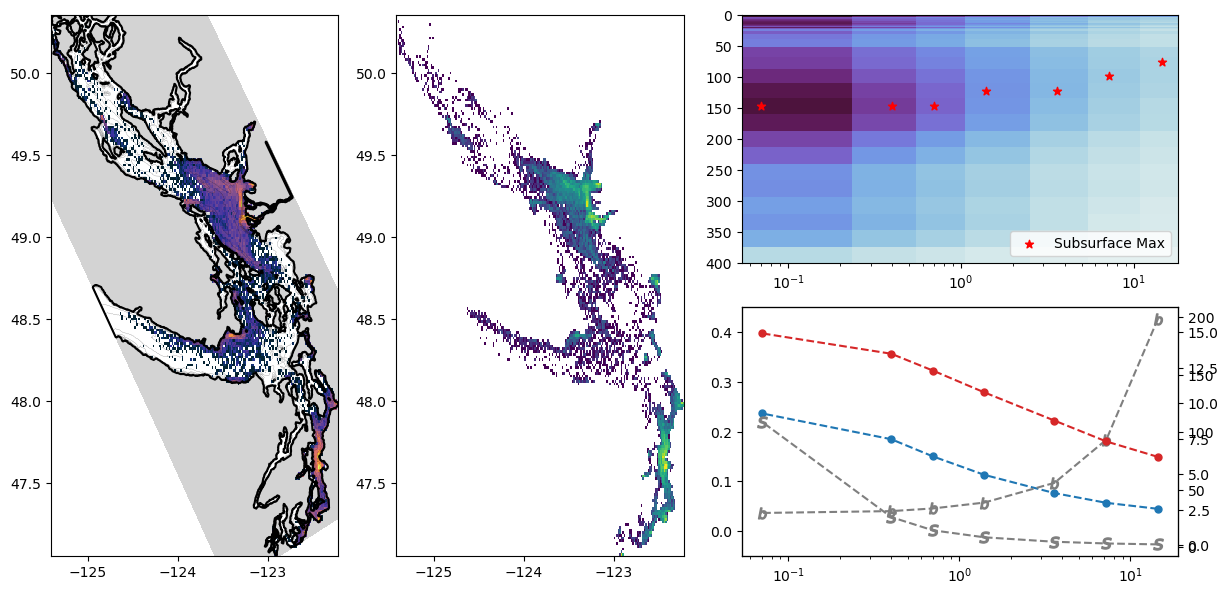

In [30]:
import cmocean
cm = cmocean.cm.matter
N = 200
alpha = '3,600 s'
hn, xedges, yedges, image0 = axes[0].hist2d(LON,LAT,N,norm=colors.LogNorm())
axes[0].clear()
xlen = haversine(yedges[0], xedges[0], yedges[0], xedges[1])
ylen = haversine(yedges[0], xedges[0], yedges[1], xedges[0])

sarea = xlen*ylen
axes[0].contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
axes[0].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
axes[0].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

h0, xedgesn, yedgesn, image0 = axes[0].hist2d(LON,LAT,[xedges, yedges],weights=concs[alpha][1]*(LON/LON)*5e6/(sarea*27.75),cmap =cmocean.cm.thermal,norm=colors.LogNorm())

vmax = np.max(h0)
h, xedges0, yedges0, image = axes[1].hist2d(LON1,LAT1,[xedges, yedges],weights=concs[alpha][1]*(LON1/LON1)*5e6/(sarea*27.75),norm=colors.LogNorm())
fig

In [31]:
alphs

{'180 s': 14.5,
 '360 s': 7.23,
 '720 s': 3.6,
 '1,800 s': 1.4,
 '3,600 s': 0.7,
 '6,120 s': 0.4,
 '36,000 s': 0.07}

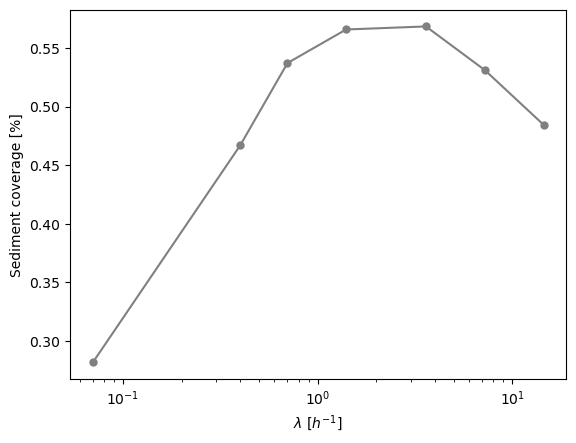

In [34]:
x = np.array(list(alphs.values()))
plt.plot(x,np.array([3907,4284,4585,4564,4333,3766,2272])*sarea/(1e6*SSCAREA),'.-',markersize=10,color='grey')
plt.ylabel(r'Sediment coverage [%]')
#plt.xlim(3600/65000,3600/200)
plt.xscale("log")
#plt.title(r'$\lambda$ effect on Sedimentation')
plt.xlabel(r'$\lambda$ $[h^{-1}]$')
plt.savefig('cover.pdf')

In [ ]:
Xedges,Yedges = np.meshgrid(xedges,yedges)
ii_sed = np.zeros_like(Xedges)
jj_sed = np.zeros_like(Xedges)
for i in range(N):
    for j in range(N):
        jjj,iii = finder2(Yedges[i,j],Xedges[i,j])
        ii_sed[i,j]=iii
        jj_sed[i,j]=jjj

/tmp/ipykernel_129017/356066591.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  image0 = axes[0].pcolormesh(ii_sed[:-1,:-1],jj_sed[:-1,:-1],h0.T,cmap=cmocean.cm.thermal,norm=colors.LogNorm(vmin=1e-2,vmax=1e2),snap = True)
/tmp/ipykernel_129017/356066591.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  image=axes[1].pcolormesh(ii_sed[:-1,:-1],jj_sed[:-1,:-1],H ,cmap=cmap_custom,norm = mcolors.SymLogNorm(linthresh=1e-4, vmin=-100,vmax=100, base=10),


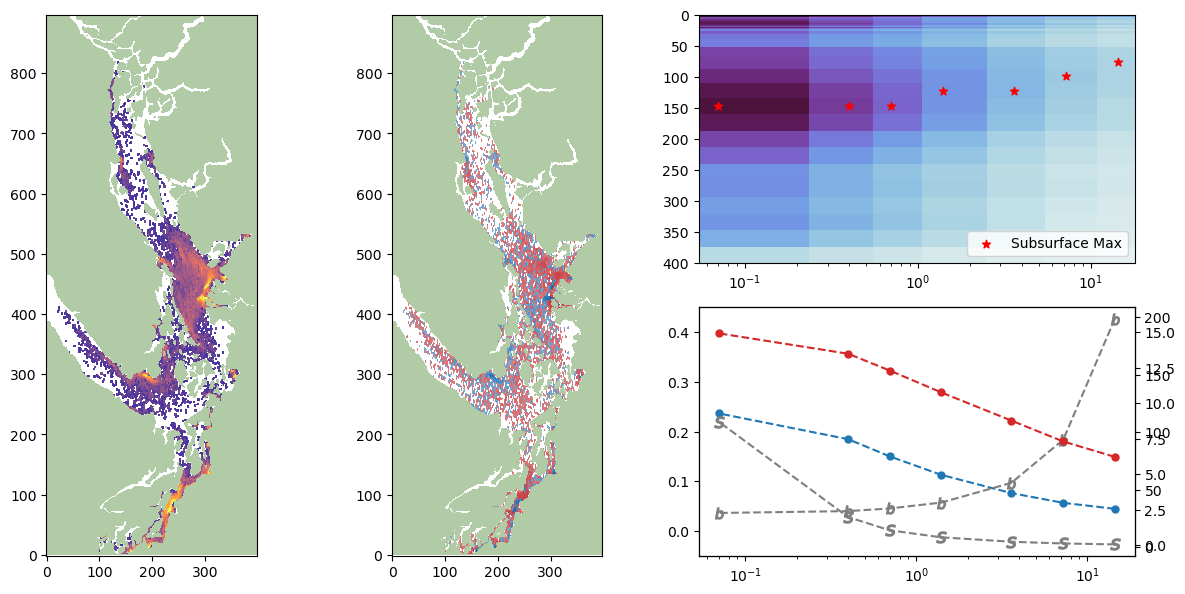

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

x = np.linspace(0,397,398)
y = np.linspace(0,897,898)
X, Y =np.meshgrid(x,y)
axes[0].clear()
#image0 = axes[0].contourf(ii_sed[:-1,:-1],jj_sed[:-1,:-1], h0.T,norm=colors.LogNorm(),levels=np.logspace(-2,2,100),cmap = cmocean.cm.thermal,extend='both',vmin=1e-2,vmax=1e2)
image0 = axes[0].pcolormesh(ii_sed[:-1,:-1],jj_sed[:-1,:-1],h0.T,cmap=cmocean.cm.thermal,norm=colors.LogNorm(vmin=1e-2,vmax=1e2),snap = True)
image0.cmap.set_under('black')
#axes[0].contour(X,Y, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
axes[0].contourf(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='#B1CBA6')
#axes[0].contour(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',linewidths=0.1)
f = 1.14
axes[0].set_aspect(f)

axes[1].clear()
#image = axes[1].contourf(ii_sed[1:,1:],jj_sed[1:,1:], (100*(h-h0)/h0).T,levels=np.linspace(-100,100,101),cmap = 'coolwarm',extend='both')
#axes[1].contour(X,Y, mask.mbathy[0,:,:],colors='k',linewidths=0.1)

H = ((h-h0)).T
cmap_custom = mcolors.LinearSegmentedColormap.from_list(
    "CustomMap",
    [(0, cm.Blues(0.8)), (0.5, "white"), (1, cm.Reds(0.8))]
)
image=axes[1].pcolormesh(ii_sed[:-1,:-1],jj_sed[:-1,:-1],H ,cmap=cmap_custom,norm = mcolors.SymLogNorm(linthresh=1e-4, vmin=-100,vmax=100, base=10),
                       snap = True)
axes[1].contourf(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='#B1CBA6')
axes[1].set_aspect(f)
fig


In [ ]:
cbar0 = plt.colorbar(image,ax=axes[1],pad=0.07,extend='both')
cbar0.set_label(r"Difference", fontsize=10)
cbar0.ax.yaxis.set_label_coords(0.25, 0.5)
# cbar0.set_ticks(np.arange(-100,101,25)) 
cbar1 =plt.colorbar(image0,ax=axes[0],pad=0.07,extend='max')#,orientation='horizontal')
cbar1.set_label(r"[MFm$^{-2}$d$^{-1}$]", fontsize=10)
cbar1.ax.yaxis.set_label_coords(0.15, 0.5)
cbar1.set_ticks(np.logspace(-2,2,5)) 
cbar2 = plt.colorbar(aa,ax=axes[2],pad=0.07,aspect=10)#,orientation='horizontal
cbar2.set_label(r"[MFm$^{-3}$]", fontsize=10)
cbar2.ax.yaxis.set_label_coords(0.06, 0.5)

/tmp/ipykernel_129017/1742422868.py:1: UserWarning: Adding colorbar to a different Figure <Figure size 1200x600 with 7 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar0 = plt.colorbar(image,ax=axes[1],pad=0.07,extend='both')
/tmp/ipykernel_129017/1742422868.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 1200x600 with 8 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar1 =plt.colorbar(image0,ax=axes[0],pad=0.07,extend='max')#,orientation='horizontal')
/tmp/ipykernel_129017/1742422868.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 1200x600 with 9 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar2 = plt.colorbar(aa,ax=axes[2],pad=0.07,aspect=10)#,orientation='horizontal


<Figure size 640x480 with 0 Axes>

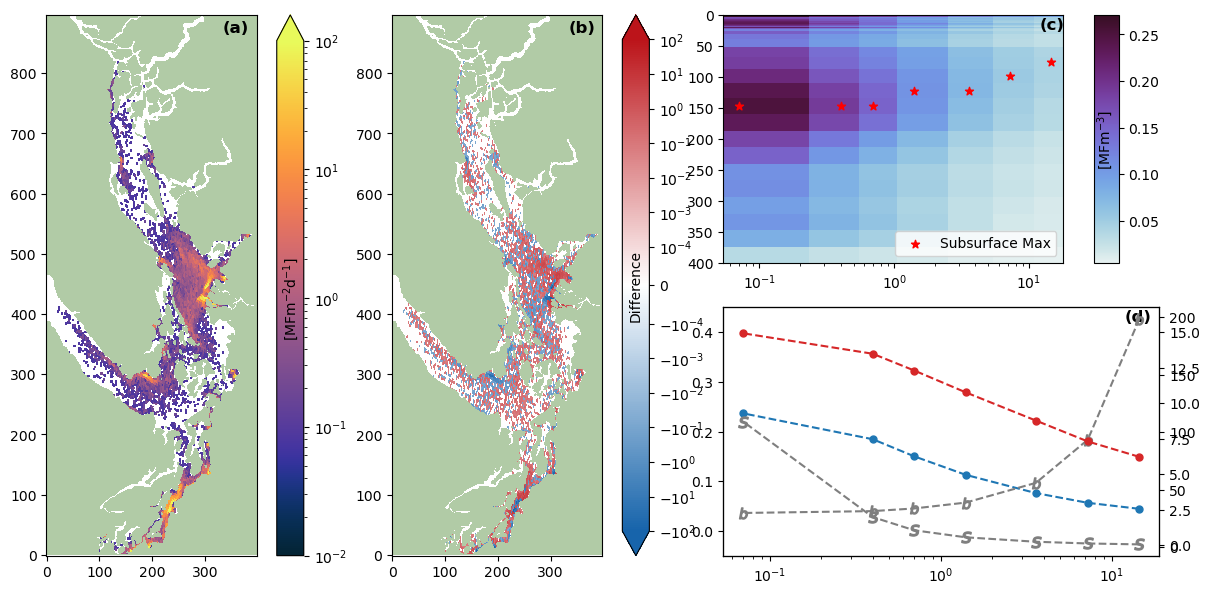

In [ ]:
letters = ['(a)', '(b)', '(c)', '(d)']

axes[0].text(0.84, 0.99, letters[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold', va='top')
axes[1].text(0.84, 0.99, letters[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold', va='top')
axes[2].text(0.93, 0.99, letters[2], transform=axes[2].transAxes, fontsize=12, fontweight='bold', va='top')
axes[3].text(0.92, 0.99, letters[3], transform=axes[3].transAxes, fontsize=12, fontweight='bold', va='top')
fig

In [ ]:
axes[3].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].set_title(r'Sedimentation for fast $\lambda$')
#axes[1].set_title(r'$\alpha$: 0.06 vs '+ str('{:3.2f}'.format(int(alpha1.split(' ')[0].replace(",", ""))/3600))+' h')
axes[1].set_title(r'$\lambda$: 0.7 - 14.5 h$^{-1}$')

axes[2].set_title(r'Impact on depth profile')
axes[3].set_title(r'Other impacts')
axes[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

axes[2].set_ylabel(r'Depth [m]')
axes[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].tick_params(axis='y', which='both', left=False,  labelleft=False)
axes[0].tick_params(axis='y', which='both', left=False,  labelleft=False)

axes[3].set_ylabel(r'Mean concentration [MF m$^{-3}$]')
axes[3].set_xlabel(r'$\lambda$ [h$^{-1}$]')
axes3.set_ylabel(r'Mean distance travelled [km]')
axes4.set_ylabel(r'Sink timescale [d]')
axes4.set_ylim([-5,220])
axes4.spines['right'].set_position(('outward', 35))

axes[3].yaxis.label.set_color(p0[0].get_color())
axes3.yaxis.label.set_color(p1[0].get_color())
axes4.yaxis.label.set_color(p2[0].get_color())

In [ ]:
fig.subplots_adjust(wspace=0.05, hspace=0.1)

#Here we squish the 4th pannel to have the same width as the rest
box = axes[3].get_position()
axes[3].set_position([box.x0+0.05, box.y0, box.width * 0.78, box.height])  # 

box = axes[2].get_position()
axes[2].set_position([box.x0+0.05, box.y0, box.width, box.height])  # 
box = cbar2.ax.get_position()
cbar2.ax.set_position([box.x0+0.05, box.y0, box.width, box.height])  # 

box = axes[1].get_position()
axes[1].set_position([box.x0-0.02, box.y0, box.width, box.height])  # 
box = cbar0.ax.get_position()
cbar0.ax.set_position([box.x0-0.02, box.y0, box.width, box.height])  # 


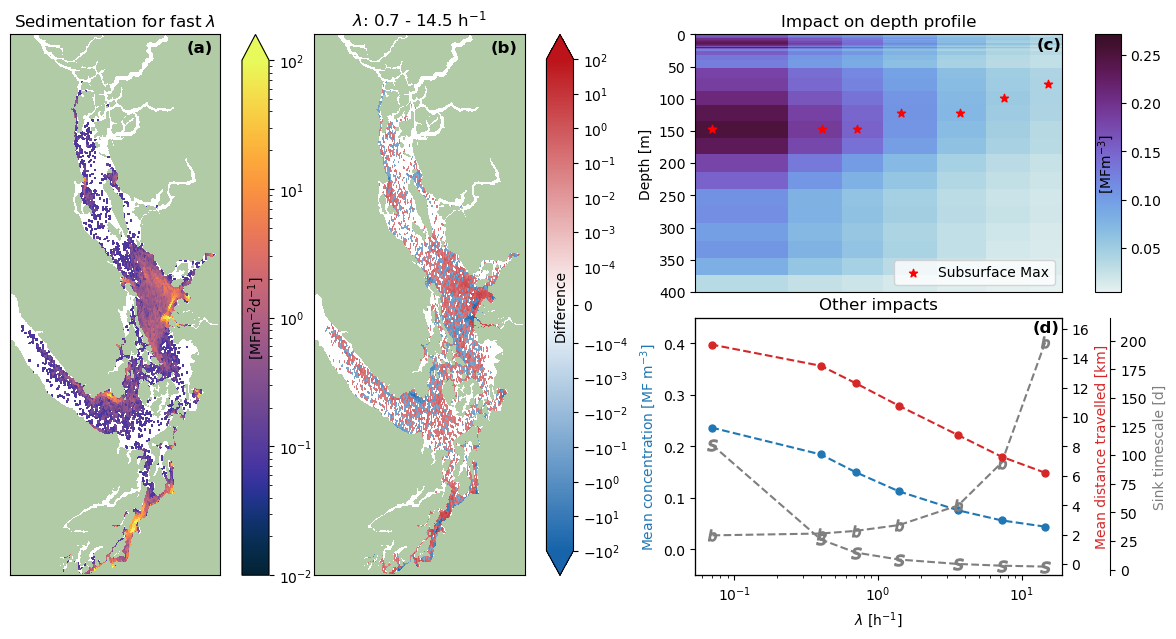

In [ ]:
fig
fig.savefig('lambdafig_0.pdf', bbox_inches='tight')